In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_validate,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/MyDrive/datasets

/content/drive/MyDrive/datasets


In [ ]:
df=pd.read_csv("/content/drive/MyDrive/datasets/Maternal Health Risk Data Set.csv")
df.head()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk


In [ ]:
df.shape

(1014, 7)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 55.6+ KB


In [ ]:
df["RiskLevel"].value_counts()

,count
RiskLevel,
low risk,406
mid risk,336
high risk,272


In [ ]:
df.describe()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate
count,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000
mean,29.871795,113.198225,76.460552,8.725986,98.665089,74.301775
std,13.474386,18.403913,13.885796,3.293532,1.371384,8.088702
min,10.000000,70.000000,49.000000,6.000000,98.000000,7.000000
25%,19.000000,100.000000,65.000000,6.900000,98.000000,70.000000
50%,26.000000,120.000000,80.000000,7.500000,98.000000,76.000000
75%,39.000000,120.000000,90.000000,8.000000,98.000000,80.000000
max,70.000000,160.000000,100.000000,19.000000,103.000000,90.000000


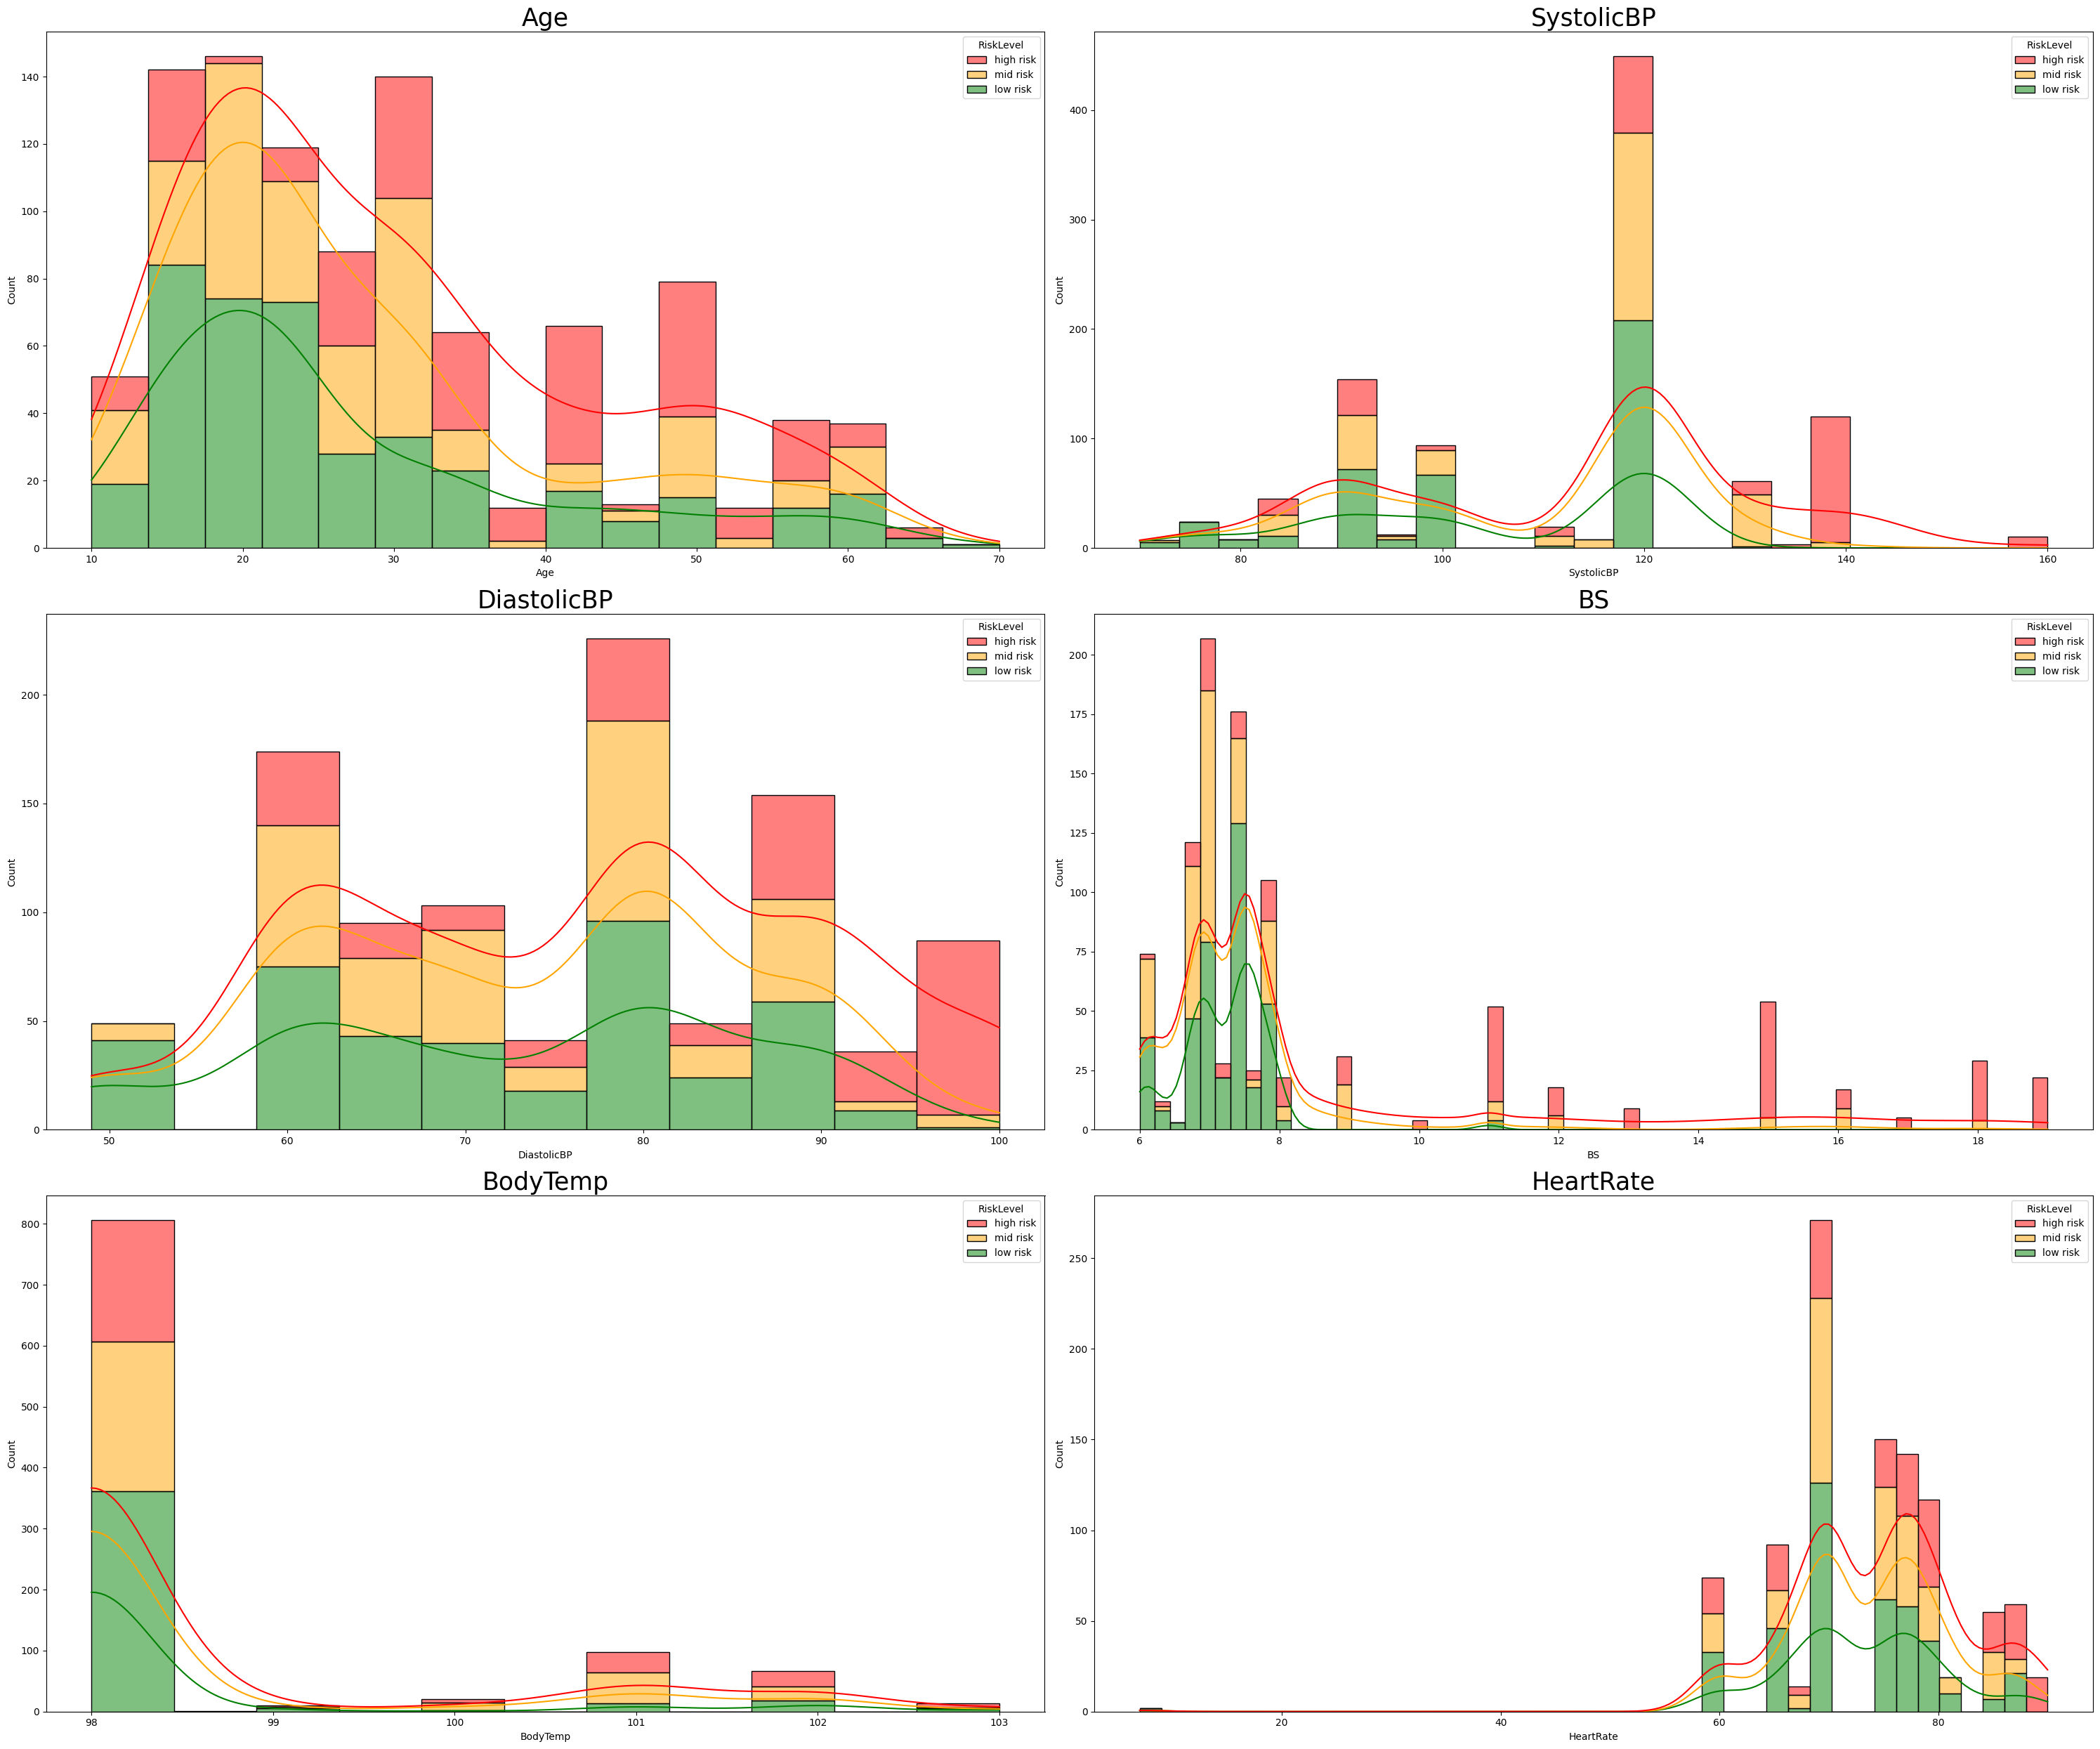

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(30,25))
risk_level_order = ['high risk', 'mid risk', 'low risk']

for ax, column in zip(axes.flatten(), df.columns):
  sns.histplot(data=df, x=column, hue='RiskLevel', ax=ax, kde=True,
               hue_order=risk_level_order, multiple= 'stack', palette={'low risk': 'green', 'mid risk': 'orange', 'high risk': 'red'},
               element='bars')
  ax.set_title(f"{column}", fontsize=25)
plt.tight_layout()
plt.savefig('maternal_features_description.png')
plt.show()

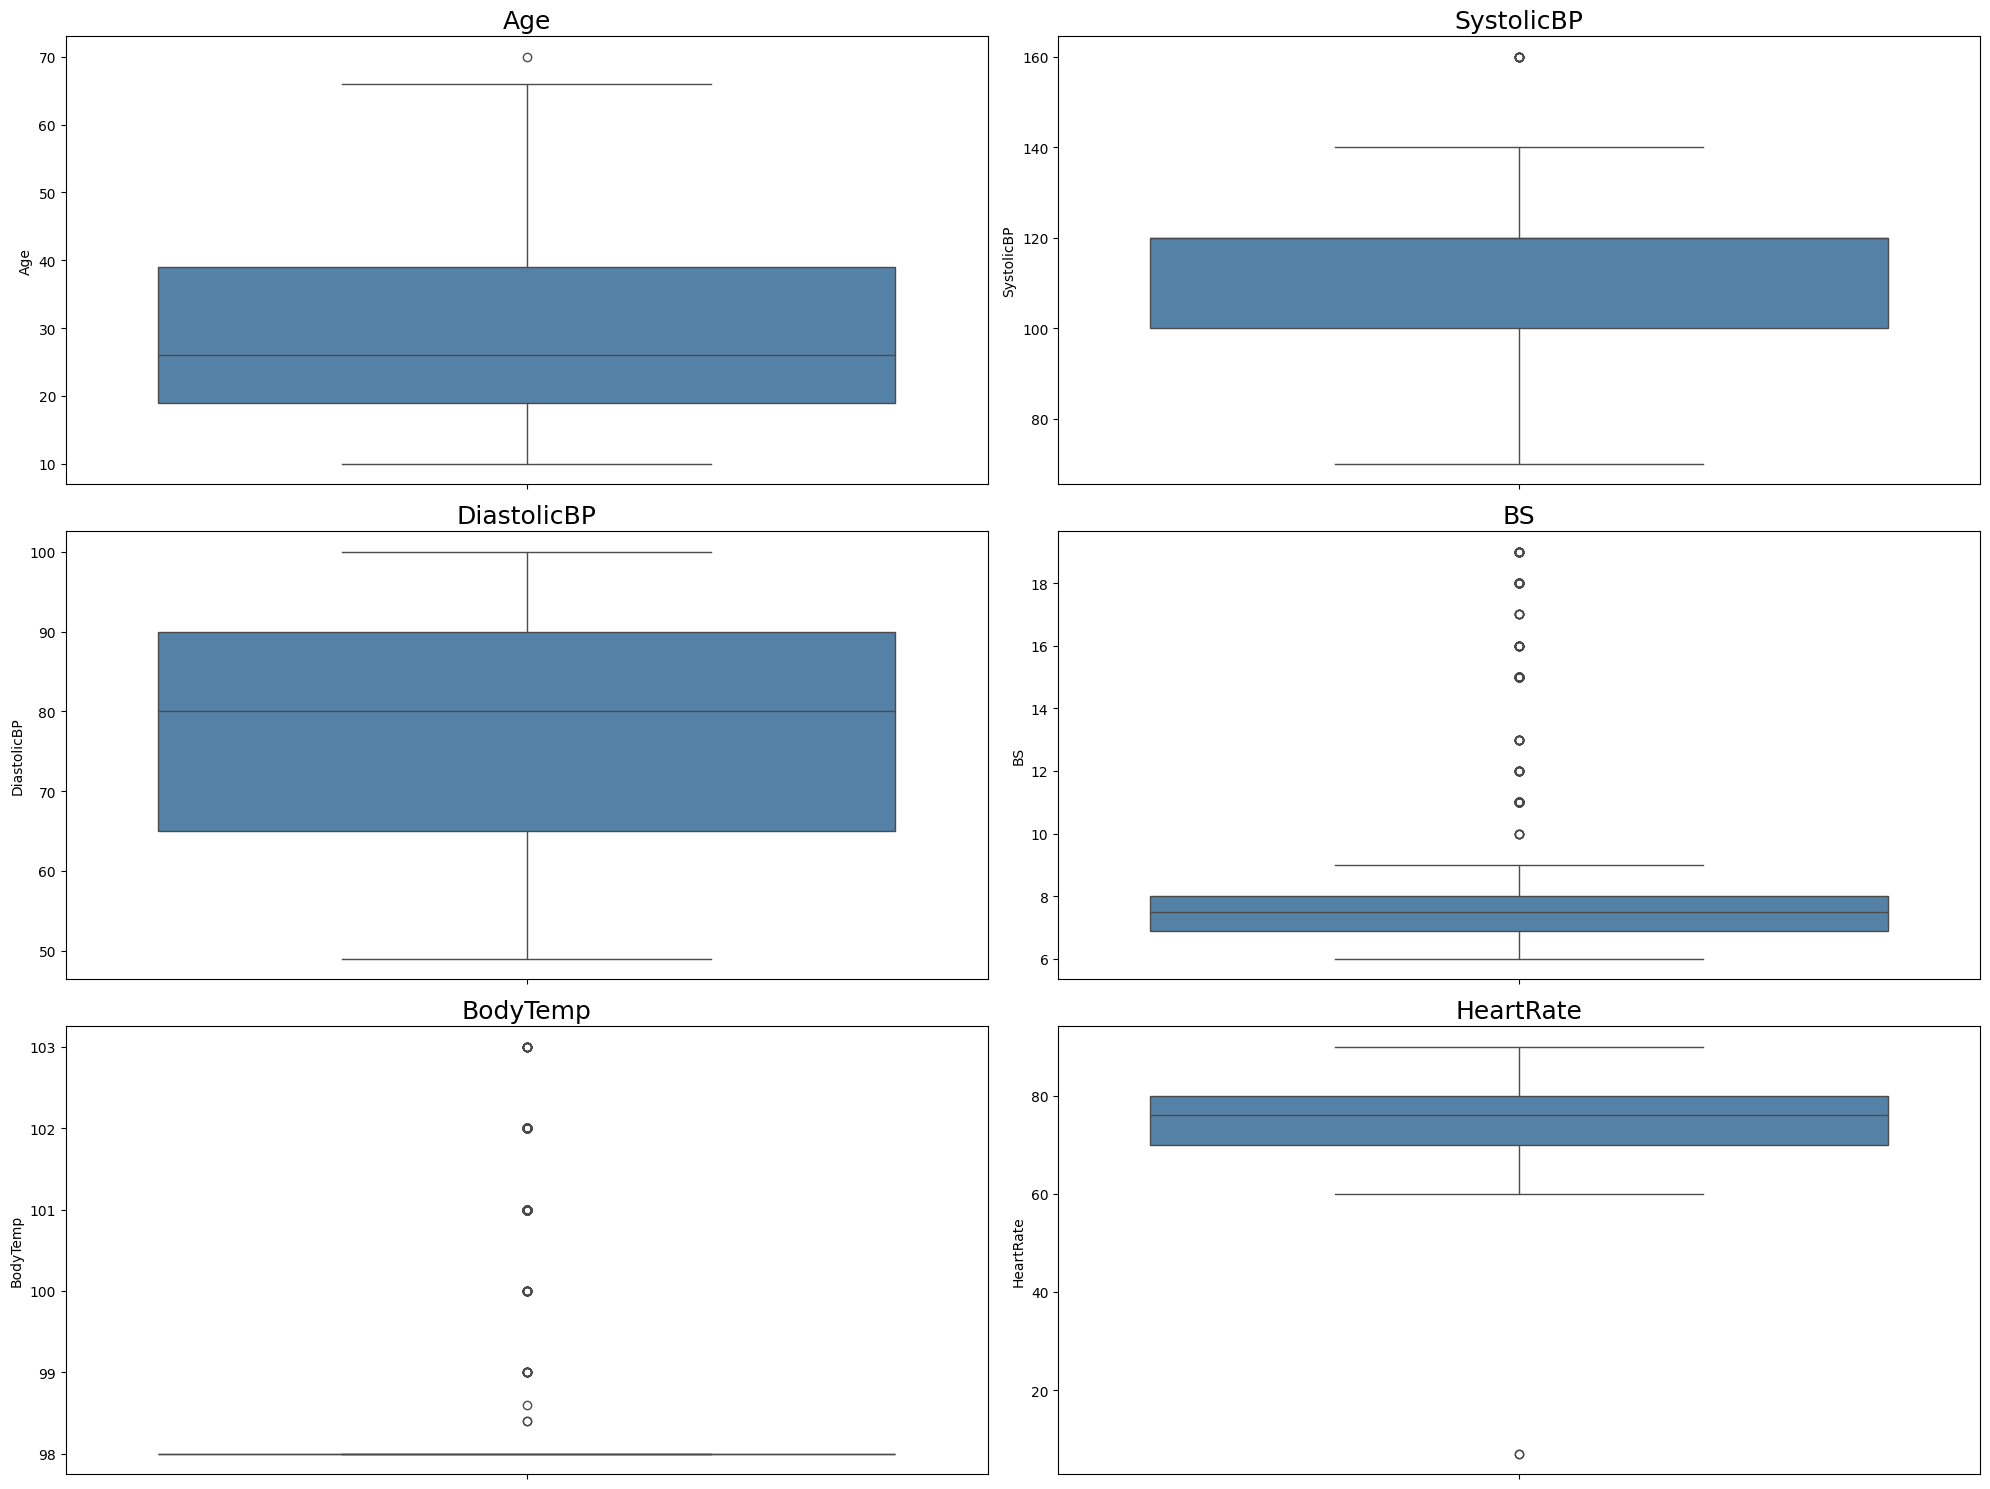

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20,15))

for ax, column in zip(axes.flatten(), df.columns):
  sns.boxplot(y=df[column], color="#4682B4", ax=ax)
  ax.set_title(f"{column}", fontsize=18)
plt.tight_layout()
plt.savefig('maternal_features_boxplot.png')
plt.show()

In [ ]:
risk_mapping ={"low risk":0, "mid risk":1, "high risk":2}
df["RiskLevel"] = df["RiskLevel"].map(risk_mapping)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   int64  
dtypes: float64(2), int64(5)
memory usage: 55.6 KB


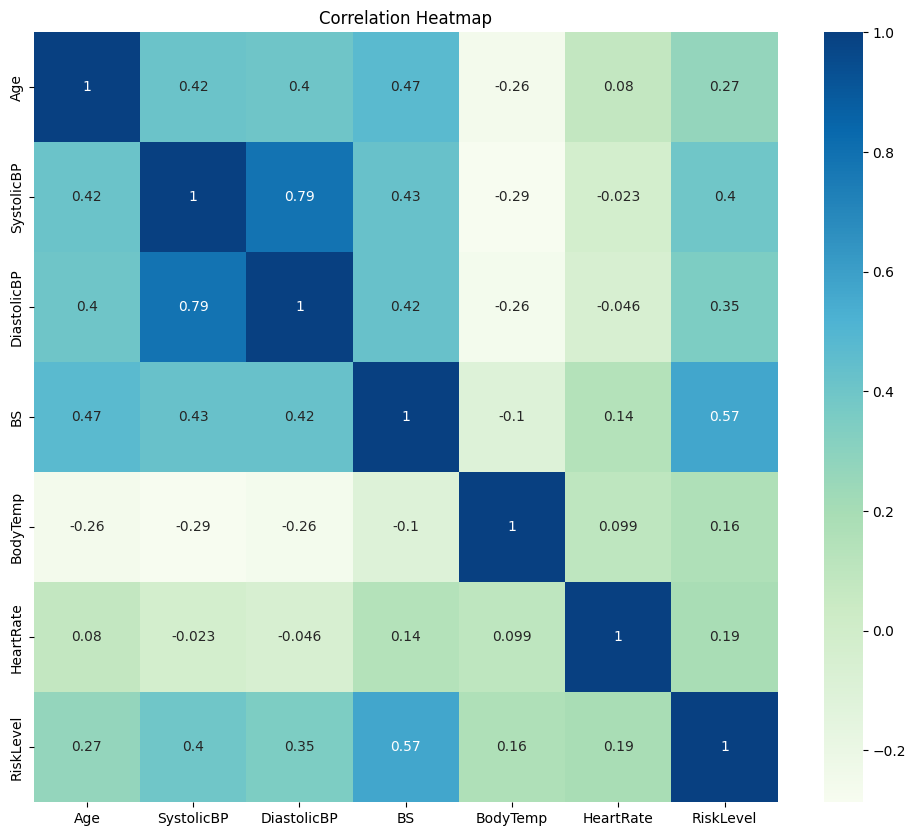

In [ ]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), annot=True, cmap="GnBu")
plt.title("Correlation Heatmap")
plt.savefig("correlation_heatmap.png")
plt.show()

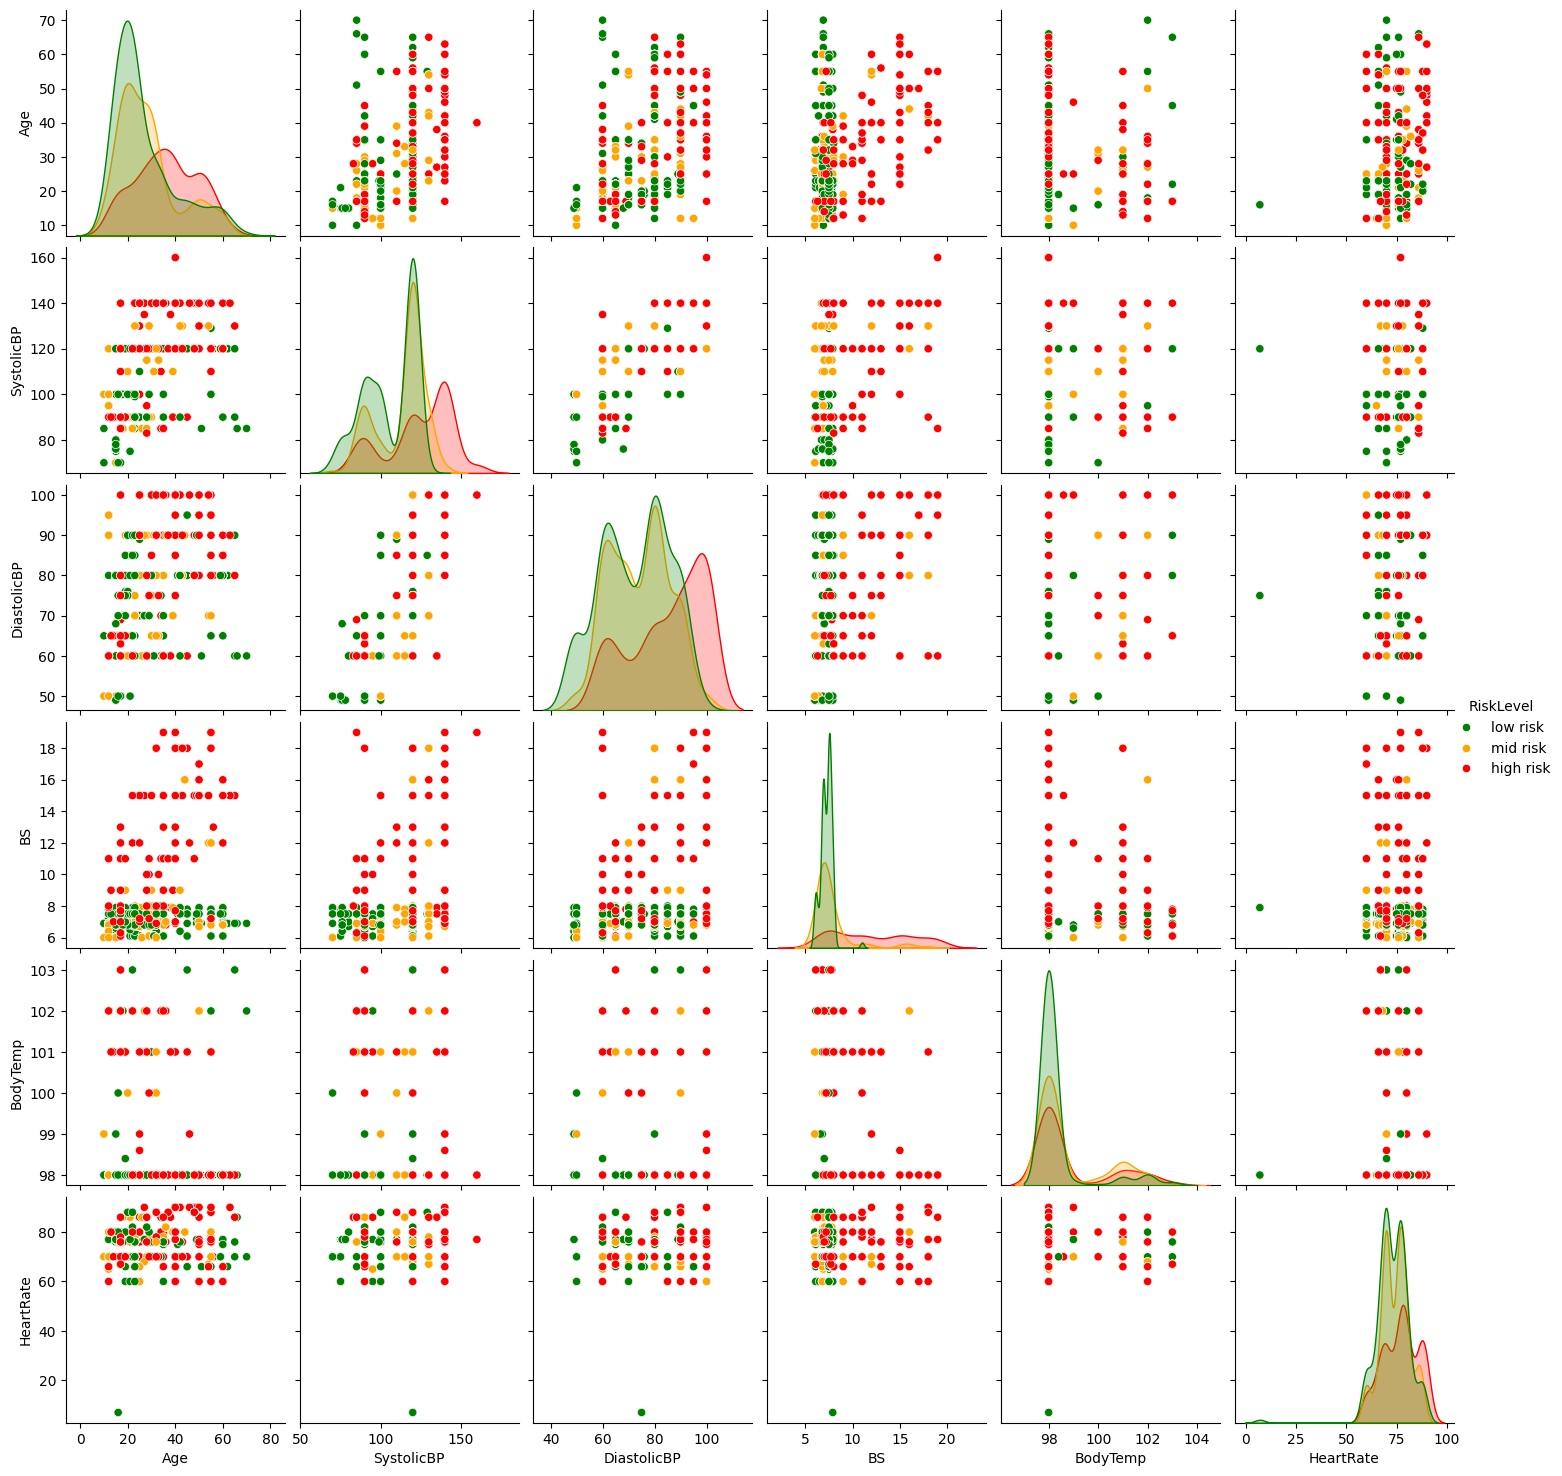

In [ ]:
risk_colors={0:"green", 1:"orange", 2:"red"}
plot=sns.pairplot(df, hue="RiskLevel", palette=risk_colors,  )

legend_label={"0":"low risk", "1":"mid risk", "2":"high risk"}
for text, label in zip(plot._legend.texts, legend_label.values()):
  text.set_text(label)
plt.savefig("pairplot.png")
plt.show()

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
X=df[["SystolicBP", "DiastolicBP"]]
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

      Variable       VIF
0   SystolicBP  79.96833
1  DiastolicBP  79.96833


In [ ]:
df=df.drop(["SystolicBP"], axis=1)

In [ ]:
df.HeartRate.sort_values().head()

,HeartRate
499,7
908,7
1000,60
1010,60
705,60


In [ ]:
df=df.drop(df.index[df.HeartRate == 7])

In [ ]:
df.HeartRate.sort_values().head()

,HeartRate
976,60
967,60
939,60
947,60
940,60


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1012 entries, 0 to 1013
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1012 non-null   int64  
 1   DiastolicBP  1012 non-null   int64  
 2   BS           1012 non-null   float64
 3   BodyTemp     1012 non-null   float64
 4   HeartRate    1012 non-null   int64  
 5   RiskLevel    1012 non-null   int64  
dtypes: float64(2), int64(4)
memory usage: 55.3 KB


# **Training**

In [ ]:
df.columns

Index(['Age', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate', 'RiskLevel'], dtype='object')

In [ ]:
columns=['Age', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate']
scale_X=StandardScaler()
X=pd.DataFrame(scale_X.fit_transform(df.drop(["RiskLevel"], axis=1)), columns=columns)
y=df["RiskLevel"]

In [ ]:
X.head()

,Age,DiastolicBP,BS,BodyTemp,HeartRate
0,-0.363796,0.254566,1.903633,-0.485808,1.538308
1,0.378765,0.974379,1.296644,-0.485808,-0.589878
2,-0.066772,-0.465247,-0.220828,0.972192,0.740239
3,0.007484,0.614473,-0.524323,-0.485808,-0.589878
4,0.378765,-1.185059,-0.797468,-0.485808,0.208192


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify =y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((809, 5), (203, 5), (809,), (203,))

In [ ]:
X_train.head()

,Age,DiastolicBP,BS,BodyTemp,HeartRate
266,-0.141028,-1.185059,-0.554672,-0.485808,1.006262
744,0.081740,-1.185059,-0.797468,-0.485808,0.208192
554,1.492607,1.694192,2.207127,-0.485808,0.075180
869,0.081740,-1.185059,-0.797468,-0.485808,0.208192
198,-0.066772,-0.465247,-0.797468,-0.485808,0.474215


In [ ]:
LogisticRegression=LogisticRegression()
logistic_regression_mod=LogisticRegression.fit(X_train, y_train)
print(f"Logistic Regression Accuracy: {round(logistic_regression_mod.score(X_test, y_test),3)}")
pred_logistick=logistic_regression_mod.predict(X_test)

Logistic Regression Accuracy: 0.64


In [ ]:
scores_logistic=cross_val_score(LogisticRegression, X_train, y_train, cv=3, scoring='accuracy')
print(f"Scores(Cross_Validate) for Logistic Regression Model: {scores_logistic}")
print(f"Mean Score: {round(scores_logistic.mean(),3)}")
print(f"Standard Deviation: {round(scores_logistic.std(),3)}")

Scores(Cross_Validate) for Logistic Regression Model: [0.6037037  0.5962963  0.57992565]
Mean Score: 0.593
Standard Deviation: 0.01


In [ ]:
param_LR = {'tol': [0.0001, 0.0002, 0.0003],
            'C': [0.01, 0.1, 1, 10,100],
            'intercept_scaling': [1, 2,3,4],
            'solver': ['newton-cg', 'lbfgs', 'liblinear'],
            'max_iter': [100, 200, 300]
}

In [ ]:
GridSearchCV_LR = GridSearchCV(estimator=LogisticRegression(),
                               param_grid=param_LR,
                               cv=3,
                               scoring='accuracy',
                               return_train_score=True,
                               )

In [ ]:
GridSearchCV_LR.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'intercept_scaling': [1, 2, 3, 4],
                         'max_iter': [100, 200, 300],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear'],
                         'tol': [0.0001, 0.0002, 0.0003]},
             return_train_score=True, scoring='accuracy')

In [ ]:
print(f"Best estimator :{GridSearchCV_LR.best_estimator_}")
print(f"Best Parameters: {GridSearchCV_LR.best_params_}")
print(f"Best Score: {round(GridSearchCV_LR.best_score_,3)}")

Best estimator :LogisticRegression(C=0.01, solver='liblinear')
Best Parameters: {'C': 0.01, 'intercept_scaling': 1, 'max_iter': 100, 'solver': 'liblinear', 'tol': 0.0001}
Best Score: 0.602


In [ ]:
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix

lr= LogisticRegression(C=0.01, intercept_scaling=1, max_iter=100, solver='liblinear', tol=0.0001, random_state=42)
lr_mod = lr.fit(X_train, y_train)
pred_logistic_regression = mod.predict(X_test)

mse_val = mean_squared_error(y_test, pred_logistic_regression)
rmse_val = np.sqrt(mse_val)

train_score = mod.score(X_train, y_train)
test_score = mod.score(X_test, y_test)

print(f"Train Accuracy (tuned model): {round(train_score, 3)}")
print(f"Test Accuracy (tuned model): {round(test_score, 3)}")
print(f"Mean Squared Error (Test, tuned model): {round(mse_val, 3)}")
print(f"Root Mean Squared Error (Test, tuned model): {round(rmse_val, 3)}")
print(f"Classification Report (Test, tuned model):\n{classification_report(y_test, pred_logistic_regression)}")
print(confusion_matrix(y_test, pred_logistic_regression))

Train Accuracy (tuned model): 0.609
Test Accuracy (tuned model): 0.635
Mean Squared Error (Test, tuned model): 0.512
Root Mean Squared Error (Test, tuned model): 0.716
Classification Report (Test, tuned model):
              precision    recall  f1-score   support

           0       0.59      0.88      0.70        81
           1       0.56      0.21      0.30        67
           2       0.77      0.80      0.79        55

    accuracy                           0.64       203
   macro avg       0.64      0.63      0.60       203
weighted avg       0.63      0.64      0.59       203

[[71  6  4]
 [44 14  9]
 [ 6  5 44]]


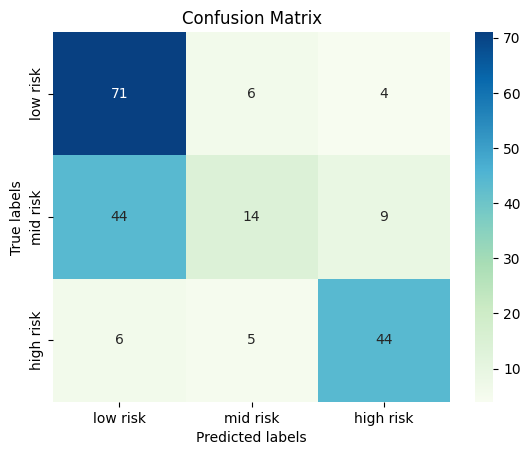

In [ ]:
ax=plt.subplot()
sns.heatmap(confusion_matrix(y_test, pred_logistic_regression), annot=True, ax=ax, cmap="GnBu")

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['low risk', 'mid risk', 'high risk'])
ax.yaxis.set_ticklabels(['low risk', 'mid risk', 'high risk'])
plt.savefig("confusion_matrix_logistic.png")

**knn**

In [ ]:
knn=KNeighborsClassifier()
knn_mod=knn.fit(X_train, y_train)
print(f"KNN Accuracy: {round(knn_mod.score(X_test, y_test),3)}")
pred_knn=knn_mod.predict(X_test)

KNN Accuracy: 0.665


In [ ]:
scores_knn=cross_val_score(KNeighborsClassifier(), X_train, y_train, cv=3, scoring='accuracy')
print(f"Scores(Cross_Validate) for KNN Model: {scores_knn}")
print(f"Mean Score: {round(scores_knn.mean(),3)}")
print(f"Standard Deviation: {round(scores_knn.std(),3)}")

Scores(Cross_Validate) for KNN Model: [0.61481481 0.68148148 0.62453532]
Mean Score: 0.64
Standard Deviation: 0.029


In [ ]:
param_knn = {'leaf_size':list(range(1,30)),
    'n_neighbors':list(range(1,21)),
    'p':[1,2],
    'weights':['uniform','distance']
}


In [ ]:
GridSearchCV_knn = GridSearchCV(estimator=KNeighborsClassifier(),
                               param_grid=param_knn,
                               cv=3,
                               scoring='accuracy',
                                return_train_score=True,
                               )

In [ ]:
GridSearchCV_knn.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid={'leaf_size': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                       23, 24, 25, 26, 27, 28, 29],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20],
                         'p': [1, 2], 'weights': ['uniform', 'distance']},
             return_train_score=True, scoring='accuracy')

In [ ]:
print(f"Best estimator :{GridSearchCV_knn.best_estimator_}")
print(f"Best Parameters: {GridSearchCV_knn.best_params_}")
print(f"Best Score: {round(GridSearchCV_knn.best_score_,3)}")

Best estimator :KNeighborsClassifier(leaf_size=1, n_neighbors=10, weights='distance')
Best Parameters: {'leaf_size': 1, 'n_neighbors': 10, 'p': 2, 'weights': 'distance'}
Best Score: 0.795


In [ ]:
knn=KNeighborsClassifier(leaf_size=1, n_neighbors=10, p=2, weights='distance')
knn_mod=knn.fit(X_train,y_train)
pred_knn=knn_mod.predict(X_test)

mse_knn=mean_squared_error(y_test, pred_knn)
rmse_knn=np.sqrt(mean_squared_error(y_test, pred_knn))
score_knn_train=knn_mod.score(X_train, y_train)
score_knn_test=knn_mod.score(X_test, y_test)

In [ ]:
print(f"Train Accuracy (tuned model): {round(score_knn_train, 3)}")
print(f"Test Accuracy (tuned model): {round(score_knn_test, 3)}")
print(f"Mean Squared Error (Test, tuned model): {round(mse_knn, 3)}")
print(f"Root Mean Squared Error (Test, tuned model): {round(rmse_knn, 3)}")
print(f"Classification Report (Test, tuned model):\n{classification_report(y_test, pred_knn)}")
print(confusion_matrix(y_test, pred_knn))


Train Accuracy (tuned model): 0.934
Test Accuracy (tuned model): 0.837
Mean Squared Error (Test, tuned model): 0.251
Root Mean Squared Error (Test, tuned model): 0.501
Classification Report (Test, tuned model):
              precision    recall  f1-score   support

           0       0.87      0.77      0.82        81
           1       0.77      0.85      0.81        67
           2       0.88      0.93      0.90        55

    accuracy                           0.84       203
   macro avg       0.84      0.85      0.84       203
weighted avg       0.84      0.84      0.84       203

[[62 17  2]
 [ 5 57  5]
 [ 4  0 51]]


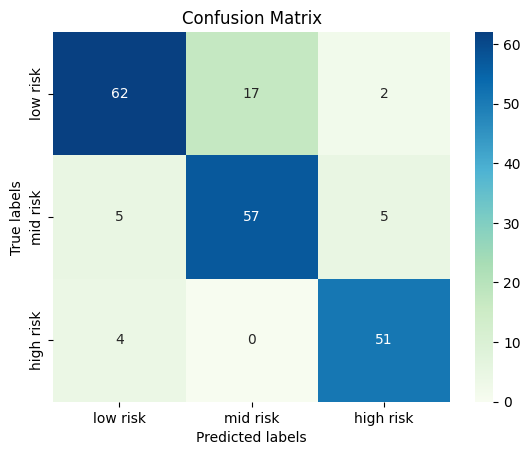

In [ ]:
ax=plt.subplot()
sns.heatmap(confusion_matrix(y_test, pred_knn), annot=True, ax=ax, cmap="GnBu")

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['low risk', 'mid risk', 'high risk'])
ax.yaxis.set_ticklabels(['low risk', 'mid risk', 'high risk'])
plt.savefig("confusion_matrix_knn.png")

## **Random Forest Classifier**

In [ ]:
rf = RandomForestClassifier(random_state=42)
rf_mod = rf.fit(X_train, y_train)
print(f"Random Forest Accuracy: {round(rf_mod.score(X_test, y_test), 3)}")
pred_rf = rf_mod.predict(X_test)

Random Forest Accuracy: 0.837


In [ ]:
scores_rf = cross_val_score(RandomForestClassifier(random_state=42), X_train, y_train, cv=3, scoring='accuracy')
print(f"Scores (Cross_Validate) for Random Forest Model: {scores_rf}")
print(f"Mean Score: {round(scores_rf.mean(), 3)}")
print(f"Standard Deviation: {round(scores_rf.std(), 3)}")

Scores (Cross_Validate) for Random Forest Model: [0.80740741 0.8037037  0.82156134]
Mean Score: 0.811
Standard Deviation: 0.008


In [ ]:
param_rf = {'min_samples_split': [2, 6, 20],
    'min_samples_leaf': [1,2,4],
    'n_estimators': [50, 100, 200, 300, 400],
    'max_depth': [None, 10, 20, 30],
    'criterion': ['gini', 'entropy']
}

In [ ]:
GridSearchCV_rf = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                               param_grid=param_rf,
                               cv=3,
                               scoring='accuracy',
                               return_train_score=True,
                               )

In [ ]:
GridSearchCV_rf.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 6, 20],
                         'n_estimators': [50, 100, 200, 300, 400]},
             return_train_score=True, scoring='accuracy')

In [ ]:
print(f"Best estimator: {GridSearchCV_rf.best_estimator_}")
print(f"Best Parameters: {GridSearchCV_rf.best_params_}")
print(f"Best Score: {round(GridSearchCV_rf.best_score_, 3)}")

Best estimator: RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=300,
                       random_state=42)
Best Parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best Score: 0.82


In [ ]:
rf_tuned = GridSearchCV_rf.best_estimator_
rf_mod= rf_tuned.fit(X_train, y_train)
pred_rf_tuned = rf_tuned.predict(X_test)

mse_rf = mean_squared_error(y_test, pred_rf_tuned)
rmse_rf = np.sqrt(mse_rf)

train_score_rf = rf_tuned.score(X_train, y_train)
test_score_rf = rf_tuned.score(X_test, y_test)

print(f"Train Accuracy (tuned model): {round(train_score_rf, 3)}")
print(f"Test Accuracy (tuned model): {round(test_score_rf, 3)}")
print(f"Mean Squared Error (Test, tuned model): {round(mse_rf, 3)}")
print(f"Root Mean Squared Error (Test, tuned model): {round(rmse_rf, 3)}")
print(f"Classification Report (Test, tuned model):\n{classification_report(y_test, pred_rf_tuned)}")
print(confusion_matrix(y_test, pred_rf_tuned))

Train Accuracy (tuned model): 0.923
Test Accuracy (tuned model): 0.828
Mean Squared Error (Test, tuned model): 0.246
Root Mean Squared Error (Test, tuned model): 0.496
Classification Report (Test, tuned model):
              precision    recall  f1-score   support

           0       0.82      0.80      0.81        81
           1       0.78      0.76      0.77        67
           2       0.88      0.95      0.91        55

    accuracy                           0.83       203
   macro avg       0.83      0.84      0.83       203
weighted avg       0.83      0.83      0.83       203

[[65 14  2]
 [11 51  5]
 [ 3  0 52]]


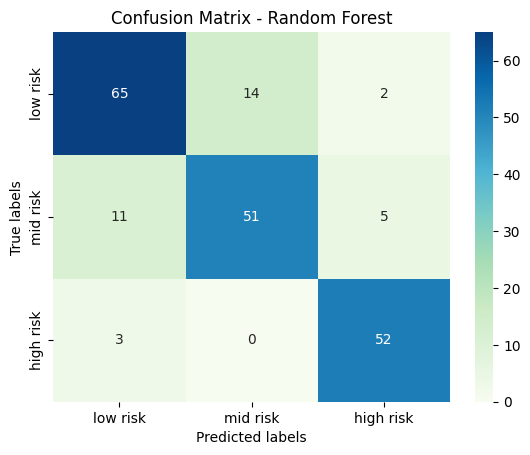

In [ ]:
ax = plt.subplot()
sns.heatmap(confusion_matrix(y_test, pred_rf_tuned), annot=True, ax=ax, cmap="GnBu")

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix - Random Forest')
ax.xaxis.set_ticklabels(['low risk', 'mid risk', 'high risk'])
ax.yaxis.set_ticklabels(['low risk', 'mid risk', 'high risk'])
plt.savefig("confusion_matrix_random_forest.png")
plt.show()

## **Gradient Boosting Classifier**

In [ ]:
gb = GradientBoostingClassifier()
gb_mod = gb.fit(X_train, y_train)
print(f"Gradient Boosting Accuracy: {round(gb_mod.score(X_test, y_test), 3)}")
pred_gb = gb_mod.predict(X_test)

Gradient Boosting Accuracy: 0.783


In [ ]:
scores_gb = cross_val_score(gb, X_train, y_train, cv=3, scoring='accuracy')
print(f"Scores (Cross_Validate) for Gradient Boosting Model: {scores_gb}")
print(f"Mean Score: {round(scores_gb.mean(), 3)}")
print(f"Standard Deviation: {round(scores_gb.std(), 3)}")

Scores (Cross_Validate) for Gradient Boosting Model: [0.74814815 0.78518519 0.80297398]
Mean Score: 0.779
Standard Deviation: 0.023


In [ ]:
param_gb = {
    'loss': ['log_loss'],
    'n_estimators': [100, 250, 500],
    'learning_rate': [0.01, 0.05, 0.075,0.1],
    'max_depth': [3, 5, 8, 10],
    'subsample': [0.8, 1]
}

In [ ]:
GridSearchCV_gb = GridSearchCV(estimator=GradientBoostingClassifier(),
                               param_grid=param_gb,
                               cv=3,
                               scoring='accuracy',
                               return_train_score=True,
                               )

In [ ]:
GridSearchCV_gb.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.01, 0.05, 0.075, 0.1],
                         'loss': ['log_loss'], 'max_depth': [3, 5, 8, 10],
                         'n_estimators': [100, 250, 500],
                         'subsample': [0.8, 1]},
             return_train_score=True, scoring='accuracy')

In [ ]:
print(f"Best estimator: {GridSearchCV_gb.best_estimator_}")
print(f"Best Parameters: {GridSearchCV_gb.best_params_}")
print(f"Best Score: {round(GridSearchCV_gb.best_score_, 3)}")

Best estimator: GradientBoostingClassifier(learning_rate=0.01, max_depth=8, n_estimators=250,
                           subsample=0.8)
Best Parameters: {'learning_rate': 0.01, 'loss': 'log_loss', 'max_depth': 8, 'n_estimators': 250, 'subsample': 0.8}
Best Score: 0.822


In [ ]:
gb= GradientBoostingClassifier(learning_rate= 0.5, loss="log_loss", max_depth=10, n_estimators=100, subsample=1, random_state=42)
gb_mod=gb.fit(X_train, y_train)
pred_gb = gb.predict(X_test)

mse_gb = mean_squared_error(y_test, pred_gb)
rmse_gb = np.sqrt(mse_gb)

train_score_gb = gb.score(X_train, y_train)
test_score_gb = gb.score(X_test, y_test)

print(f"Train Accuracy ( model): {round(train_score_gb, 3)}")
print(f"Test Accuracy ( model): {round(test_score_gb, 3)}")
print(f"Mean Squared Error (Test,  model): {round(mse_gb, 3)}")
print(f"Root Mean Squared Error (Test,  model): {round(rmse_gb, 3)}")
print(f"Classification Report (Test,  model):\n{classification_report(y_test, pred_gb)}")
print(confusion_matrix(y_test, pred_gb))

Train Accuracy ( model): 0.934
Test Accuracy ( model): 0.842
Mean Squared Error (Test,  model): 0.232
Root Mean Squared Error (Test,  model): 0.481
Classification Report (Test,  model):
              precision    recall  f1-score   support

           0       0.86      0.80      0.83        81
           1       0.80      0.79      0.80        67
           2       0.87      0.96      0.91        55

    accuracy                           0.84       203
   macro avg       0.84      0.85      0.85       203
weighted avg       0.84      0.84      0.84       203

[[65 13  3]
 [ 9 53  5]
 [ 2  0 53]]


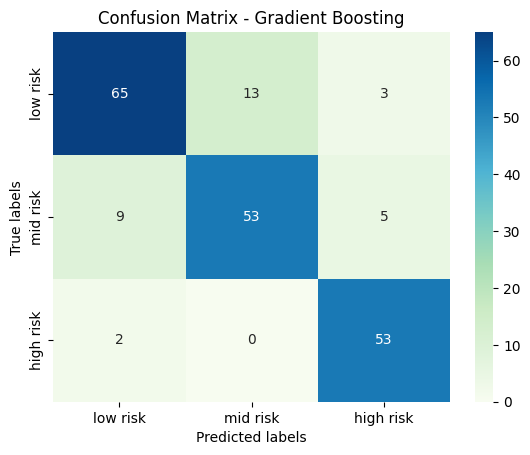

In [ ]:
ax = plt.subplot()
sns.heatmap(confusion_matrix(y_test, pred_gb), annot=True, ax=ax, cmap="GnBu")

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix - Gradient Boosting')
ax.xaxis.set_ticklabels(['low risk', 'mid risk', 'high risk'])
ax.yaxis.set_ticklabels(['low risk', 'mid risk', 'high risk'])
plt.savefig("confusion_matrix_gradient_boosting.png")
plt.show()

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

results=pd.DataFrame({
    "models":["Logistic Regression","K-Nearest Neighbors", "Random Forest Classifier", "Gradient Boosting Classifier"],
    "Train Score": [
        cross_val_score(lr_mod, X_train, y_train, cv=3).mean(),
        cross_val_score(knn_mod, X_train, y_train, cv=3).mean(),
        cross_val_score(rf_mod, X_train, y_train, cv=3).mean(),
        cross_val_score(gb_mod, X_train, y_train, cv=3).mean()
    ],

    "Best Score":[
        lr_mod.score(X_test, y_test),
        knn_mod.score(X_test, y_test),
        rf_mod.score(X_test, y_test),
        gb_mod.score(X_test, y_test)
    ]
})

metrics= ["precision", "recall", "f1"]
for metric in metrics:
  results[f"{metric.capitalize()}"]=[
      precision_recall_fscore_support(y_test, model.predict(X_test), average='weighted')[metrics.index(metric)]
      for model in [lr_mod, knn_mod, rf_mod, gb_mod]
  ]

result_df=results.sort_values(by="Best Score", ascending=False)
result_df=result_df.set_index("Best Score")
result_df

,models,Train Score,Precision,Recall,F1
Best Score,,,,,
0.842365,Gradient Boosting Classifier,0.819547,0.841706,0.842365,0.841021
0.837438,K-Nearest Neighbors,0.794818,0.840899,0.837438,0.836922
0.827586,Random Forest Classifier,0.819542,0.826056,0.827586,0.826407
0.635468,Logistic Regression,0.601960,0.628104,0.635468,0.593824


In [ ]:
import pickle

In [ ]:
pickle.dump(gb_mod, open("model.sav", "wb"))

In [ ]:
import pickle

In [ ]:
maternal_model=pickle.load(open("/content/drive/MyDrive/datasets/model.sav", "rb"))

In [ ]:
maternal_model.predict([[1,2,78,56,76,]])

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


array([2])